In [5]:
import os
import re

import copy
import json
import numpy as np
import time
import pickle
import random
import pandas as pd
import sys
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.special import softmax
import platform

In [6]:
from helper import read_pred_all, x_aug, xx_aug, \
                   ens, merge_aug, read_log, \
                   read_pkl, NC_o, \
                   where2cut, boxes, where2cutsin, here2cut, ratio2cut
from sklearn.manifold import TSNE
from scipy.stats import kstest, pearsonr
from bhatta_dist import bhatta_dist

In [8]:
#
# masked peptides for data augmentation
#

EXP   = 'bbbp'  
times = 5
prefx = {'bbbp':'d3_'} # d1_ | d2_ | d3_

input_data = 'bbbp/{}test.txt'.format(prefx[EXP])
output_data = input_data[:-4]+'_a1x{}.txt'.format(times)

x_aug(input_data, output_data, times=times)

input_data = 'bbbp/{}train.txt'.format(prefx[EXP])
output_data = input_data[:-4]+'_a1x{}.txt'.format(times)

x_aug(input_data, output_data, times=times)

print('> generating augmented data for {} for {} times: done.'.format(EXP, times))

read input data: bbbp/d3_test.txt
~~~ augmenting 592 items ~~~
~~~ augmenting 592 items ~~~
~~~ augmenting 592 items ~~~
~~~ augmenting 592 items ~~~
read input data: bbbp/d3_train.txt
~~~ augmenting 2367 items ~~~
~~~ augmenting 2367 items ~~~
~~~ augmenting 2367 items ~~~
~~~ augmenting 2367 items ~~~
> generating augmented data for bbbp for 5 times: done.


In [11]:
#%% ========== ========== ========== ==========
#
# complete result analysis
#
### ========== ========== ========== ==========

EXP     = 'bbbp' 
AA      = 1
times   = 8
max_len = 75  

aug   = '_a{}x{}'.format(AA, times) if AA!=0 else ''
# aug   = '_a{}x{}'.format(2, times-10) if AA!=0 else ''
prefx = {'test':'', 'MLCPP':'MLCPP_', 'bbbp':'d3_', 'tox':'tox_'}

# read raw/aug data
test_data = 'bbbp/{}test{}.txt'.format(prefx[EXP], aug) 
df = pd.read_csv(test_data, sep='\t')
label_true = df['RT'].values

train_data = 'bbbp/{}train{}.txt'.format(prefx[EXP], aug) 
df_ = pd.read_csv(train_data, sep='\t')
label_true_ = df_['RT'].values

num  = len(label_true)
nu   = int(num / (times if AA!=0 else 1))
num_ = len(label_true_)
nu_  = int(num_ / (times if AA!=0 else 1))

print('> train data:', train_data)
print('> test data:', test_data)
print('> # training data: {}'.format(num_))
print('> # raw training data: {}'.format(nu_))
print('> # testing data: {}'.format(num))
print('> # raw testing data: {}'.format(nu))

> train data: bbbp/d3_train_a1x8.txt
> test data: bbbp/d3_test_a1x8.txt
> # training data: 18936
> # raw training data: 2367
> # testing data: 4736
> # raw testing data: 592


In [12]:
#%% load experiment
exp_name = '{}'.format(times) if AA!=0 else 'raw'
pred_dir = 'collect/{}/max{}'.format(exp_name, max_len) 
epos = np.arange(1,51)

all_pred = read_pred_all(pred_dir, epos, label_true, 
                         prefix='/{}test.pred.'.format(prefx[EXP]), 
                         aug=True) 
print('collect', all_pred.shape)


> load experiment from: collect/8/max75
no.0 epoch 1 ~ no.1 epoch 2 ~ no.2 epoch 3 ~ no.3 epoch 4 ~ no.4 epoch 5 ~ no.5 epoch 6 ~ no.6 epoch 7 ~ no.7 epoch 8 ~ no.8 epoch 9 ~ no.9 epoch 10 ~ no.10 epoch 11 ~ no.11 epoch 12 ~ no.12 epoch 13 ~ no.13 epoch 14 ~ no.14 epoch 15 ~ no.15 epoch 16 ~ no.16 epoch 17 ~ no.17 epoch 18 ~ no.18 epoch 19 ~ no.19 epoch 20 ~ no.20 epoch 21 ~ no.21 epoch 22 ~ no.22 epoch 23 ~ no.23 epoch 24 ~ no.24 epoch 25 ~ no.25 epoch 26 ~ no.26 epoch 27 ~ no.27 epoch 28 ~ no.28 epoch 29 ~ no.29 epoch 30 ~ no.30 epoch 31 ~ no.31 epoch 32 ~ no.32 epoch 33 ~ no.33 epoch 34 ~ no.34 epoch 35 ~ no.35 epoch 36 ~ no.36 epoch 37 ~ no.37 epoch 38 ~ no.38 epoch 39 ~ no.39 epoch 40 ~ no.40 epoch 41 ~ no.41 epoch 42 ~ no.42 epoch 43 ~ no.43 epoch 44 ~ no.44 epoch 45 ~ no.45 epoch 46 ~ no.46 epoch 47 ~ no.47 epoch 48 ~ no.48 epoch 49 ~ no.49 epoch 50 ~ collect (4736, 1, 50)


In [13]:
#%% train data
print('\n*****\n')
all_pred_ = read_pred_all(pred_dir, epos, label_true_, 
                          prefix='/{}test.pred.'.format(prefx[EXP]), 
                          aug=True, mode='train') 
print('collect', all_pred_.shape)


*****

> load experiment from: collect/8/max75
no.0 epoch 1 ~ no.1 epoch 2 ~ no.2 epoch 3 ~ no.3 epoch 4 ~ no.4 epoch 5 ~ no.5 epoch 6 ~ no.6 epoch 7 ~ no.7 epoch 8 ~ no.8 epoch 9 ~ no.9 epoch 10 ~ no.10 epoch 11 ~ no.11 epoch 12 ~ no.12 epoch 13 ~ no.13 epoch 14 ~ no.14 epoch 15 ~ no.15 epoch 16 ~ no.16 epoch 17 ~ no.17 epoch 18 ~ no.18 epoch 19 ~ no.19 epoch 20 ~ no.20 epoch 21 ~ no.21 epoch 22 ~ no.22 epoch 23 ~ no.23 epoch 24 ~ no.24 epoch 25 ~ no.25 epoch 26 ~ no.26 epoch 27 ~ no.27 epoch 28 ~ no.28 epoch 29 ~ no.29 epoch 30 ~ no.30 epoch 31 ~ no.31 epoch 32 ~ no.32 epoch 33 ~ no.33 epoch 34 ~ no.34 epoch 35 ~ no.35 epoch 36 ~ no.36 epoch 37 ~ no.37 epoch 38 ~ no.38 epoch 39 ~ no.39 epoch 40 ~ no.40 epoch 41 ~ no.41 epoch 42 ~ no.42 epoch 43 ~ no.43 epoch 44 ~ no.44 epoch 45 ~ no.45 epoch 46 ~ no.46 epoch 47 ~ no.47 epoch 48 ~ no.48 epoch 49 ~ no.49 epoch 50 ~ collect (18936, 1, 50)


best ACC: 0.9611 @ epoch 43
best AUC: 0.9608 @ epoch 43


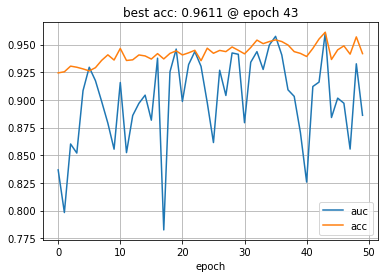

In [14]:
#%% plot learning curve
log_file = pred_dir+'/{}test.txt.log'.format(prefx[EXP])
lines = read_log(log_file)

logs = []
for li in lines:
    if li.startswith('>>') and not li.endswith('min'): 
        metrics = [float(i) for i in li.split(':')[1].split('|')]
        logs.append(metrics)
logs = np.array(logs)

# show learning curve
plt.plot(logs[:,-1], label='auc')
plt.plot(logs[:,-2], label='acc')
plt.xlabel('epoch')
plt.grid()
plt.legend()
b_acc = np.max(logs[:,-2])
b_epo = np.argmax(logs[:,-2])
plt.title('best acc: {} @ epoch {}'.format(b_acc,b_epo))
b_auc = np.max(logs[:,-1])
b_epo = np.argmax(logs[:,-1])
print('best ACC: {} @ epoch {}'.format(b_acc,b_epo))
print('best AUC: {} @ epoch {}'.format(b_auc,b_epo))

> generating grid: 1000


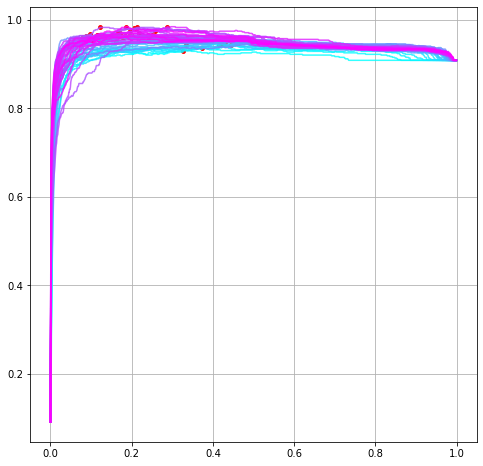

In [15]:
#%% see trend
bests, cuts = where2cut(all_pred[:nu,:,:], label_true[:nu], 
                        rang=[0.,1], step=0.001) # [0.2,0.7] | [0.9,1]
c_ts  = copy.deepcopy(cuts)
b_sts = copy.deepcopy(bests)

best acc: 0.9848 @ 43 | threshold: 0.2880


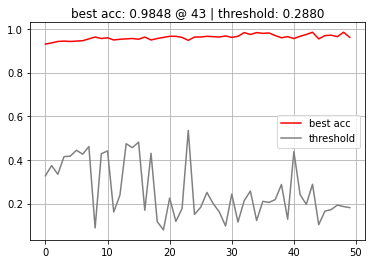

In [16]:
#%% show cuts
plt.plot(bests, color='r', label='best acc')
plt.plot(cuts, color='gray', label='threshold')
plt.grid()
plt.legend()
be_ = np.max(bests)
bee = np.argmax(bests)
bep = cuts[bee]
plt.title('best acc: {:.4f} @ {} | threshold: {:.4f}'.format(be_, bee, bep))
print('best acc: {:.4f} @ {} | threshold: {:.4f}'.format(be_, bee, bep))


> generating grid: 1000


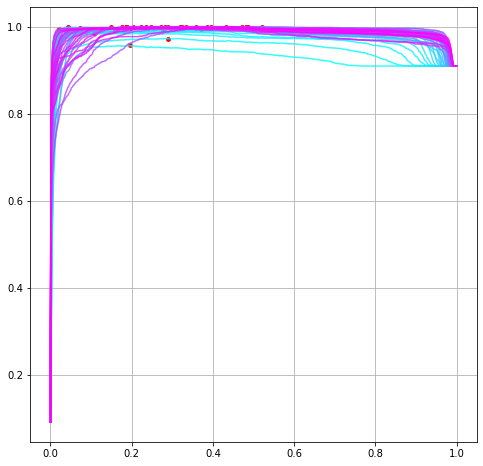

In [17]:
#%% see trend on train
bests, cuts = where2cut(all_pred_[:nu_,:,:], label_true_[:nu_], 
                        rang=[0.,1], step=0.001)

test mean threshold: 0.26037999999999994
train mean threshold: 0.28564
(-0.2754348681919425, 0.052869244375959475)


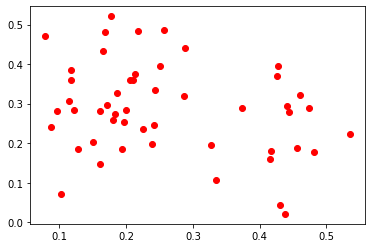

In [18]:
#%% corr: threshold
plt.scatter(c_ts, cuts, color='r')
print('test mean threshold:', np.mean(c_ts))
print('train mean threshold:', np.mean(cuts))

print(pearsonr(c_ts, cuts))

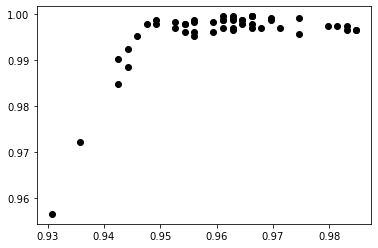

In [19]:
#%% corr: best acc
plt.scatter(b_sts, bests, color='k')

/home/horsepurve/anaconda3/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3419: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/horsepurve/anaconda3/lib/python3.9/site-packages/numpy/core/_methods.py:180: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(


single 0.9662 @ 43
@43: ACC 0.9662, SEN 0.7037, SPE 0.9926, AUC 0.9945, MCC 0.7808
0.9662162162162162
0.7037037037037037
0.9925650557620818
0.9944582128596998
0.7808343984840918


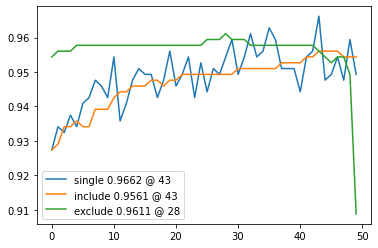

In [20]:
#%% raw test only <0.5 cut>
m_acc, predd = ens(all_pred[:nu,:,:], label_true[:nu], skip=0, mode='reg', threshold=0.5)

In [21]:
cls_true  = np.where(predd == label_true[:nu])[0]
cls_false = np.where(predd != label_true[:nu])[0]
pep_std = np.std(all_pred[:nu,0,:], axis=-1)
stat, p_value = kstest(pep_std[cls_true], pep_std[cls_false])
print(f"Kolmogorov-Smirnov Test: statistic={stat:.4f}, p-value={p_value:.4f}")
bdist = bhatta_dist(pep_std[cls_true], pep_std[cls_false])
print(f"Bhattacharyya distance: {bdist:.4f}")
#sns.distplot(pep_std[cls_true], bins=30, label='true prediction')
#sns.distplot(pep_std[cls_false], bins=30, label='false prediction')
#plt.legend()

if AA != 0:
    pep_stds = [np.std(all_pred[nod::nu,0,:]) for nod in range(nu)]
    pep_stds = np.array(pep_stds)
    stats, p_values = kstest(pep_stds[cls_true], pep_stds[cls_false])
    print(f"Kolmogorov-Smirnov Test: statistic={stats:.4f}, p-value={p_values:.4f}")
    bdists = bhatta_dist(pep_stds[cls_true], pep_stds[cls_false])
    print(f"Bhattacharyya distance: {bdists:.4f}")

if AA == 0:
    print(stat, bdist, sep='\n')
else:
    print(stat, bdist, stats, bdists, sep='\n')

Kolmogorov-Smirnov Test: statistic=0.8916, p-value=0.0000
Bhattacharyya distance: 1.2270
Kolmogorov-Smirnov Test: statistic=0.8934, p-value=0.0000
Bhattacharyya distance: 1.1225
0.8916083916083916
1.2269684479830982
0.8933566433566433
1.1224612617314327


using cut:  0.28564
single 0.9831 @ 43
@43: ACC 0.9831, SEN 0.9815, SPE 0.9833, AUC 0.9945, MCC 0.9071
0.9831081081081081
0.9814814814814815
0.983271375464684
0.9944582128596998
0.9071316326642632
EXP: AA 1, time 8, max_len 75


/home/horsepurve/anaconda3/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3419: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/horsepurve/anaconda3/lib/python3.9/site-packages/numpy/core/_methods.py:180: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(


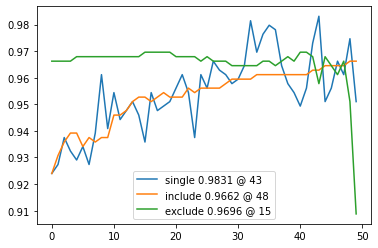

In [22]:
#%% raw test only <train mean cut>
print('using cut: ', np.mean(cuts))
m_acc, predd = ens(all_pred[:nu,:,:], label_true[:nu], skip=0, mode='reg', threshold=np.mean(cuts))


print('EXP: AA {}, time {}, max_len {}'.format(AA, times, max_len))

In [ ]:
'''
Due to the large volume of ablation studies, only the model w/ the best setting is uploaded (8x augmentation) here.
Please let me know if you need model files for additional ablation studies.
'''